# Определение возраста покупателей

Супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В моем распоряжении набор фотографий людей с указанием возраста.

# Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
BASE_PATH = '/datasets/faces'
SEED = 12345

In [3]:
img_df = pd.read_csv(f'{BASE_PATH}/labels.csv', header=0)
img_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# размер выборки
img_df.shape

(7591, 2)

In [5]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
img_df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [7]:
img_df['file_name'] = img_df['file_name'].astype('str')

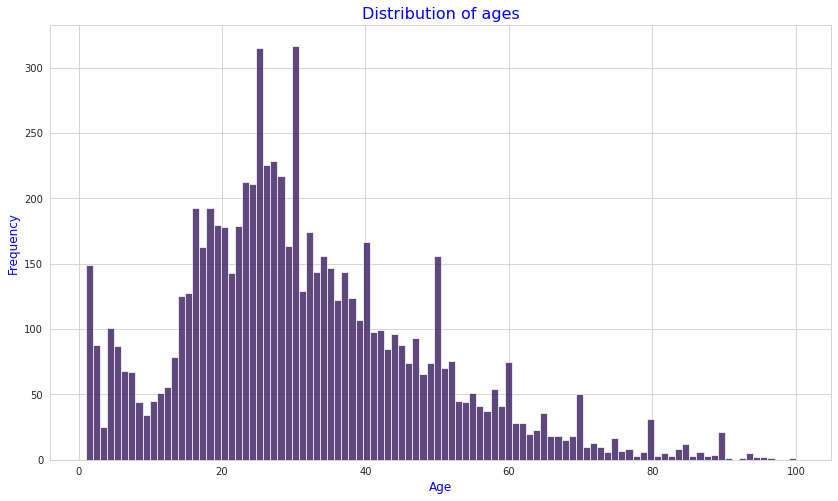

In [9]:
# график распределения возраста в выборке
plt.figure(figsize=(14, 8))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.histplot(img_df['real_age'], bins=100)
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of ages', fontsize=16, color='b')
plt.show()

*Анализ:* 
- данные возраста находятся в диапазоне значений от одного до ста лет.
- виден всплеск в начале и тяжелый хвост в конце - можно исключить нормальность распределения;
- в выборке изображений большая часть фото с людьми в возрасте от 10 до 40 лет и при случайном выборе признаков для обучения есть вероятность переобучить модель так, что она будет хорошо предсказывать людей в данной возрастной группе.
- на графике видны всплески в возрасте 30-90 лет каждые 10 лет и аномальное количество значений в возрасте 1-10 лет.

In [9]:
def load_dataset(path, dataframe):
    datagen = ImageDataGenerator(rescale=1/255.)
    
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        seed=SEED,
        rescale=1/255.
    )
    return train_datagen_flow

In [10]:
img_generator = load_dataset(BASE_PATH, img_df)

Found 7591 validated image filenames.


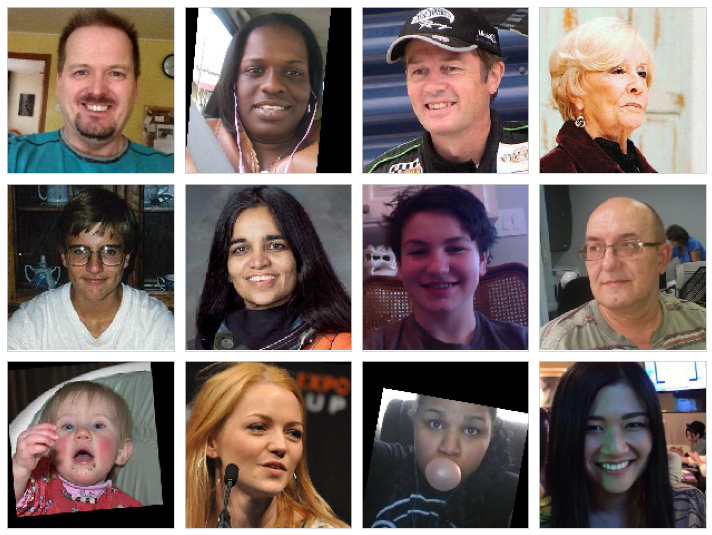

In [11]:
features, target = next(img_generator)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

*Анализ:*  изображения зашумлены, так как на картинках можно заметить людей в очках, а так же предметы, не относящиеся к внешности (микрофон, жвачка, кепка). В выборке присутствуют черно-белые фото, кадры из фильмов и фото знаменитостей. И есть фотографии, повернутые на случайный градус.

# Обучение сверточной нейронной сети ResNet50

In [12]:
def load_train(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
    )
    img_df = pd.read_csv(f'{path}/labels.csv', header=0)
    train_datagen_flow = datagen.flow_from_dataframe(
        img_df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow


def load_test(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
    )
    img_df = pd.read_csv(f'{path}/labels.csv', header=0)
    test_datagen_flow = datagen.flow_from_dataframe(
        img_df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(
        input_shape=(224, 224, 3),
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    model.compile(
        optimizer=optimizer, 
        loss='mse',
        metrics=['mae']
    )
    print(model.summary())
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

# Результат

Архитектура сети

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
=================================================================
Total params: 23,792,713
Trainable params: 23,739,593
Non-trainable params: 53,120
```

Результат

```
Train for 178 steps, validate for 60 steps
Epoch 1/7
178/178 - 71s - loss: 209.8749 - mae: 10.4246 - val_loss: 696.0708 - val_mae: 21.3888
Epoch 2/7
178/178 - 45s - loss: 70.9218 - mae: 6.4484 - val_loss: 706.1601 - val_mae: 21.5757
Epoch 3/7
178/178 - 48s - loss: 45.4587 - mae: 5.1501 - val_loss: 294.3266 - val_mae: 12.5975
Epoch 4/7
178/178 - 44s - loss: 33.7471 - mae: 4.4156 - val_loss: 136.8103 - val_mae: 9.1444
Epoch 5/7
178/178 - 45s - loss: 24.3825 - mae: 3.7136 - val_loss: 79.9671 - val_mae: 6.7072
Epoch 6/7
178/178 - 44s - loss: 18.7456 - mae: 3.2850 - val_loss: 66.8642 - val_mae: 6.2178
Epoch 7/7
178/178 - 44s - loss: 15.6359 - mae: 2.9454 - val_loss: 63.6929 - val_mae: 5.9396

60/60 - 11s - loss: 63.0858 - mae: 5.9221
Test MAE: 5.9221

```

# Вывод

Для решения задачи определения возраста покупателей была обучена сверточная нейронная сеть со следующей архитектурой:
- предобученная сверточная нейросеть ResNet50;
- Dropout с 20% "выключенных" нейронов, чтобы снизить переобучение;
- полносвязный слой Dense со 100 нейронами и функцией активации ReLU;
- выходной слой с 1 нейроном и функцией активации ReLU.

В качестве оптимизатора использовала Adam с шагом обучения learning_rate=0.0001.
Функция потерь - Mean Absolute Error.

Значение ключевой метрики **MAE на тестовых данных: 5.9221**.